In [1]:
from matplotlib import pyplot as plt
from itertools import product
# import seaborn as sns
import pandas as pd
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from scipy import signal, stats
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

from util.io.ffr import *

In [2]:
def read_epochs(sub, desc):
    '''
    reads and concatenates epochs across runs
    '''
    from bids import BIDSLayout
    layout = BIDSLayout(BIDS_ROOT, derivatives = True)
    run = lambda f: int(re.findall('run-(\w+)_', f)[0])
    fnames = layout.get(
        return_type = 'filename',
        subject = sub, 
        desc = desc
        )
    print(fnames)
    fnames.sort(key = run)
    epochs_all = [mne.read_epochs(f) for f in fnames]
    for epochs in epochs_all:
        print(epochs.info['sfreq'])
    epochs = mne.concatenate_epochs(epochs_all)
    epochs = epochs.pick('eeg')
    return epochs

In [3]:
# Load accuracies
accuracies = pd.read_csv('accuracies.csv')

In [48]:
# BIDS_ROOT = '../data/bids'
# layout = BIDSLayout(BIDS_ROOT, derivatives = True, regex_search = 'forERP')
# subs = layout.get_subjects(scope = 'erp')
# subs.sort(key = int)
# evokeds = pd.DataFrame()

# def get_condition(c):
#     predictable_and_target = int(c[0])
#     if predictable_and_target / 3 <= 1:
#         predictable = True
#     else:
#         predictable = False

#     target = predictable_and_target % 3
#     if target == 0:
#         target = 3

#     tone = c[1]

#     return predictable, target, tone

# for sub in subs:
    
#     # Read epochs
#     epochs = read_epochs(sub, 'forERP')
    
#     # Compute evokeds 
#     conditions = list(epochs.event_id.keys())
#     chans = ['Cz', 'Fz', 'FCz', 'CPz', 'Pz']
#     for c in conditions:
#         predictable, target, tone = get_condition(c)

#         for chan in chans:
#             uV = np.squeeze(epochs[c].average(picks = chan).get_data())
#             t = np.arange(-173, 527)

#             accuracy = accuracies['accuracy_group'][accuracies.sub_num == int(sub)].tolist()[0]

#             # if int(sub) in high_subs:
#             #     accuracy = 'high'
#             # elif int(sub) in low_subs:
#             #     accuracy = 'low'
#             # else:
#             #     print(f'No accuracy score for {sub}')
#             #     accuracy = 'none'

#             evoked = pd.DataFrame({
#                 'sub': sub,
#                 'chan': chan,
#                 'predictable': predictable,
#                 'target': target,
#                 'tone': tone,
#                 'accuracy': accuracy,
#                 'msec': t,
#                 'uV': uV
#             })

#             # Bind into dataframe
#             evokeds = pd.concat([evokeds, evoked])
#             evokeds = evokeds.reset_index(drop = True)
#             # break
#         # break
#     # break
# evokeds.to_csv('evokeds.csv', index = False)
evokeds = pd.read_csv('evokeds.csv')
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,2,Cz,True,1,1,low,-173,-5.368437e-07
1,2,Cz,True,1,1,low,-172,-5.779308e-07
2,2,Cz,True,1,1,low,-171,-6.682346e-07
3,2,Cz,True,1,1,low,-170,-7.665710e-07
4,2,Cz,True,1,1,low,-169,-8.883843e-07
...,...,...,...,...,...,...,...,...
2488495,41,Pz,False,3,3,high,522,5.592560e-07
2488496,41,Pz,False,3,3,high,523,5.489198e-07
2488497,41,Pz,False,3,3,high,524,5.435890e-07
2488498,41,Pz,False,3,3,high,525,5.367600e-07


In [49]:
# Rename target and tone vars to freq
mapping = {1: 110,
           2: 150,
           3: 210}

evokeds['target'] = evokeds['target'].replace(mapping)
evokeds['tone'] = evokeds['tone'].replace(mapping)
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,2,Cz,True,110,110,low,-173,-5.368437e-07
1,2,Cz,True,110,110,low,-172,-5.779308e-07
2,2,Cz,True,110,110,low,-171,-6.682346e-07
3,2,Cz,True,110,110,low,-170,-7.665710e-07
4,2,Cz,True,110,110,low,-169,-8.883843e-07
...,...,...,...,...,...,...,...,...
2488495,41,Pz,False,210,210,high,522,5.592560e-07
2488496,41,Pz,False,210,210,high,523,5.489198e-07
2488497,41,Pz,False,210,210,high,524,5.435890e-07
2488498,41,Pz,False,210,210,high,525,5.367600e-07


In [50]:
# Adjust units
evokeds['uV'] = evokeds['uV'] * 1000000
evokeds['msec'] = evokeds['msec'] - 50

In [51]:
evokeds = evokeds[(evokeds['sub'] < 10)]
np.unique(evokeds['sub'])

array([2, 3, 4, 5, 6, 7, 8, 9])

In [52]:
# Drop subjects with fewer than 80% trials
# BADS = [2, 3, 6, 33, 37]
# for bad in BADS:
#     evokeds = evokeds[evokeds['sub'] != bad]
# np.unique(evokeds['sub'])

# Plots

Text(0.5, 1.0, '110 Hz tone')

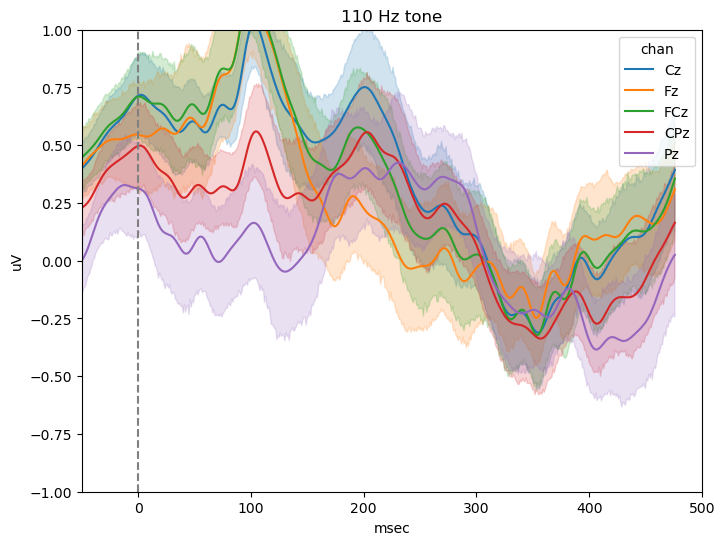

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds[evokeds.tone == 110], x = "msec", y = "uV", hue = "chan", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.set_title("110 Hz tone")

### By tone

/home/letitiayhho/ipykernel_736608/558321328.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.axes.xaxis.set_ticklabels(['', '', 100, 200, 300, 400, 500])


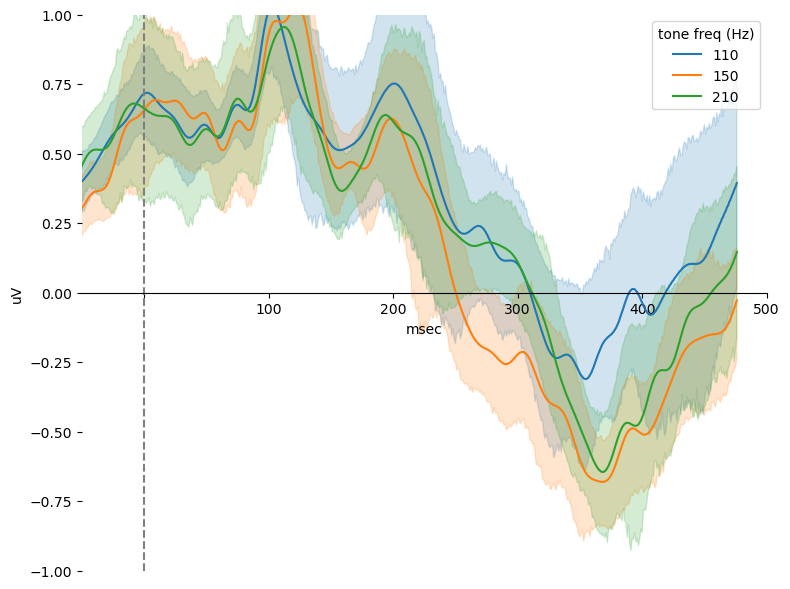

In [34]:
evokeds_Cz = evokeds[evokeds.chan == 'Cz']
evokeds_Cz = evokeds_Cz.groupby(['sub', 'tone', 'msec'], as_index = False)['uV'].mean()
rrfig, ax = plt.subplots(figsize=(8, 6))
sns.despine(left=True)
ax.spines['bottom'].set_position('center')
ax.axes.xaxis.set_ticklabels(['', '', 100, 200, 300, 400, 500])
graph = sns.lineplot(data = evokeds_Cz, x = "msec", y = "uV", hue = "tone", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.legend(title = 'tone freq (Hz)')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_ylim(-1, 1)
graph.set_xlim(-50, 500)
plt.tight_layout()
plt.savefig('../figs/ERP-by-tone.png')

### By target tone

In [10]:
# Do it by tone
evokeds_tone_1 = evokeds[evokeds.tone == 110]
evokeds_tone_2 = evokeds[evokeds.tone == 150]
evokeds_tone_3 = evokeds[evokeds.tone == 210]

# Keep only Cz
evokeds_tone_1 = evokeds_tone_1[evokeds_tone_1.chan == "Cz"]
evokeds_tone_2 = evokeds_tone_2[evokeds_tone_2.chan == "Cz"]
evokeds_tone_3 = evokeds_tone_3[evokeds_tone_3.chan == "Cz"]

/home/letitiayhho/ipykernel_736608/3686721050.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.axes.xaxis.set_ticklabels(['', '', 100, 200, 300, 400, 500])


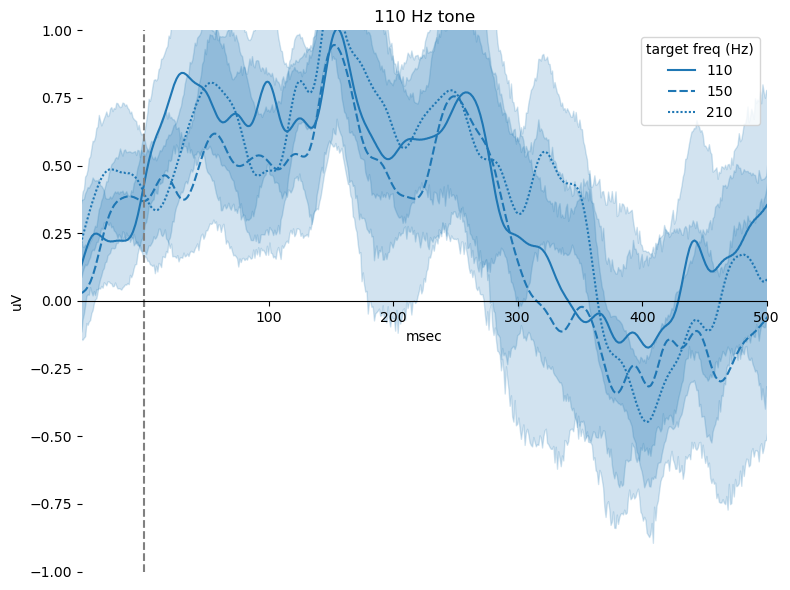

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.despine(left=True)
ax.spines['bottom'].set_position('center')
ax.axes.xaxis.set_ticklabels(['', '', 100, 200, 300, 400, 500])
evokeds_tone_1['target freq (Hz)'] = evokeds_tone_1.target
graph = sns.lineplot(data = evokeds_tone_1, x = "msec", y = "uV", style = "target freq (Hz)", ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.set_title("110 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-tone-1-by-target.png')

/scratch/local/jobs/21769458/ipykernel_1765370/3074480795.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.axes.yaxis.set_ticklabels([''])
/scratch/local/jobs/21769458/ipykernel_1765370/3074480795.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_tone_2, x = "msec", y = "uV", style = "target", palette = 'tab10', ax = ax, legend = False)


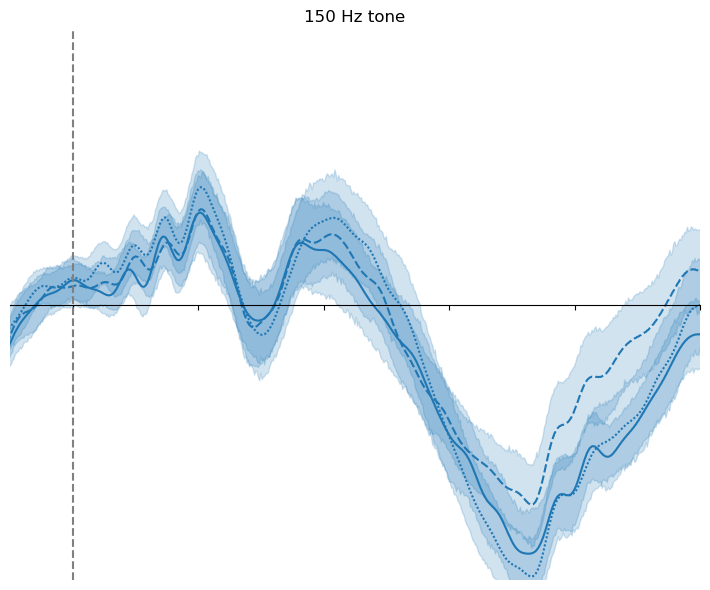

In [15]:
fig, ax = plt.subplots(figsize=(7.2, 6))

# Formatting
sns.despine(left=True)
ax.spines['bottom'].set_position('center')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([''])
ax.tick_params(left=False)

# Content
graph = sns.lineplot(data = evokeds_tone_2, x = "msec", y = "uV", style = "target", palette = 'tab10', ax = ax, legend = False)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.set_title("150 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-tone-2-by-target.png')

/scratch/local/jobs/21769458/ipykernel_1765370/303188421.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_tone_3, x = "msec", y = "uV", style = "target", palette = 'tab10', ax = ax, legend = False)


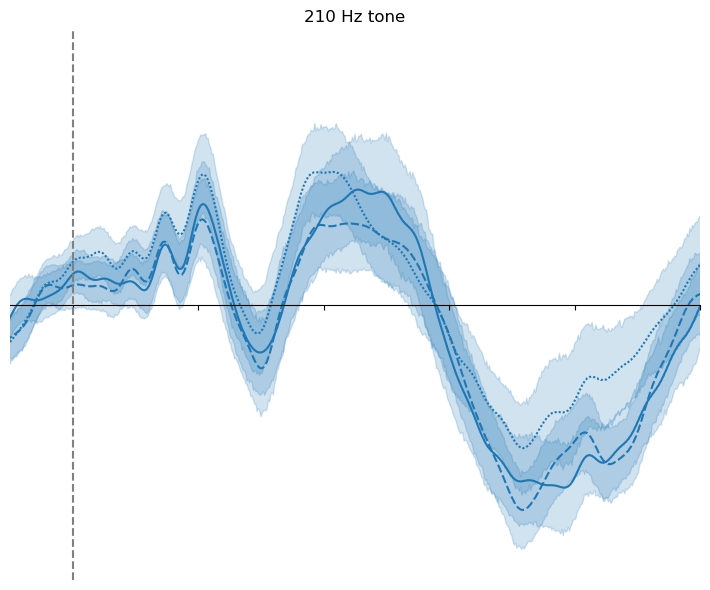

In [16]:
fig, ax = plt.subplots(figsize=(7.2, 6))

# Formatting
sns.despine(left=True)
ax.spines['bottom'].set_position('center')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.tick_params(left=False)

# Content
graph = sns.lineplot(data = evokeds_tone_3, x = "msec", y = "uV", style = "target", palette = 'tab10', ax = ax, legend = False)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.set_title("210 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-tone-3-by-target.png')

### Tone and target by predictability

/scratch/local/jobs/21769458/ipykernel_1765370/3328557810.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.axes.xaxis.set_ticklabels(['', '', 100, 200, 300, 400, 500])


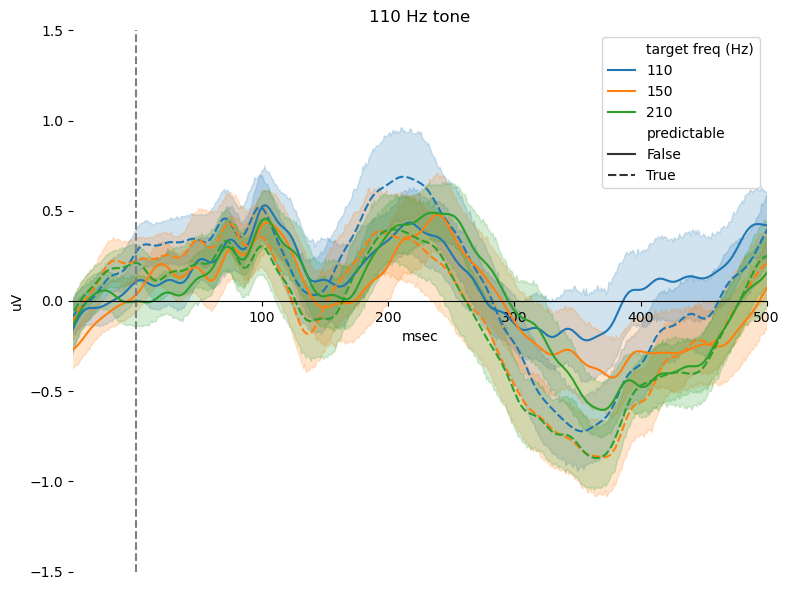

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.despine(left=True)
ax.spines['bottom'].set_position('center')
ax.axes.xaxis.set_ticklabels(['', '', 100, 200, 300, 400, 500])
evokeds_tone_1['target freq (Hz)'] = evokeds_tone_1.target
graph = sns.lineplot(data = evokeds_tone_1, x = "msec", y = "uV", hue = "target freq (Hz)", style = "predictable", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1.5, 1.5)
graph.set_title("110 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-tone-1-by-predictability.png')

/scratch/local/jobs/21769458/ipykernel_1765370/1171041632.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.axes.yaxis.set_ticklabels([''])


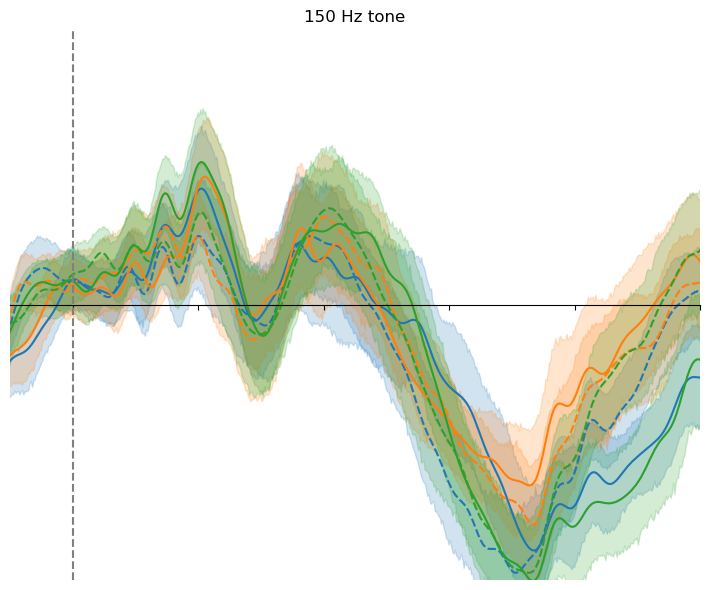

In [18]:
fig, ax = plt.subplots(figsize=(7.2, 6))

# Formatting
sns.despine(left=True)
ax.spines['bottom'].set_position('center')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([''])
ax.tick_params(left=False)

# Content
graph = sns.lineplot(data = evokeds_tone_2, x = "msec", y = "uV", hue = "target", style = "predictable", palette = 'tab10', ax = ax, legend = False)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.set_title("150 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-tone-2-by-predictability.png')

In [ ]:
fig, ax = plt.subplots(figsize=(7.2, 6))

# Formatting
sns.despine(left=True)
ax.spines['bottom'].set_position('center')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([''])
ax.tick_params(left=False)

# Content
graph = sns.lineplot(data = evokeds_tone_3, x = "msec", y = "uV", hue = "target", style = "predictable", palette = 'tab10', ax = ax, legend = False)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel(None)
graph.set_xlabel(None)
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.set_title("210 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-tone-3-by-predictability.png')

/scratch/local/jobs/21769458/ipykernel_1765370/1089624195.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.axes.yaxis.set_ticklabels([''])


### Factor in accuracies

In [81]:
# Drop 'none' accuracies
evokeds_tone_1 = evokeds_tone_1[evokeds_tone_1.accuracy != 'none']
evokeds_tone_2 = evokeds_tone_2[evokeds_tone_2.accuracy != 'none']
evokeds_tone_3 = evokeds_tone_3[evokeds_tone_3.accuracy != 'none']

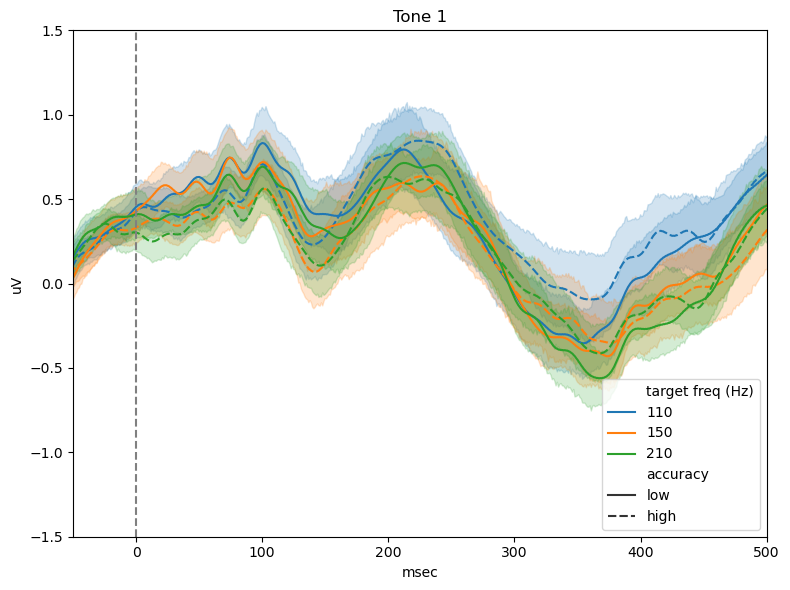

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))
evokeds_tone_1['target freq (Hz)'] = evokeds_tone_1.target
graph = sns.lineplot(data = evokeds_tone_1, x = "msec", y = "uV", hue = "target freq (Hz)", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1.5, 1.5)
graph.set_title('Tone 1')
plt.tight_layout()
plt.savefig('../figs/ERP-tone-1-by-accuracy.png')

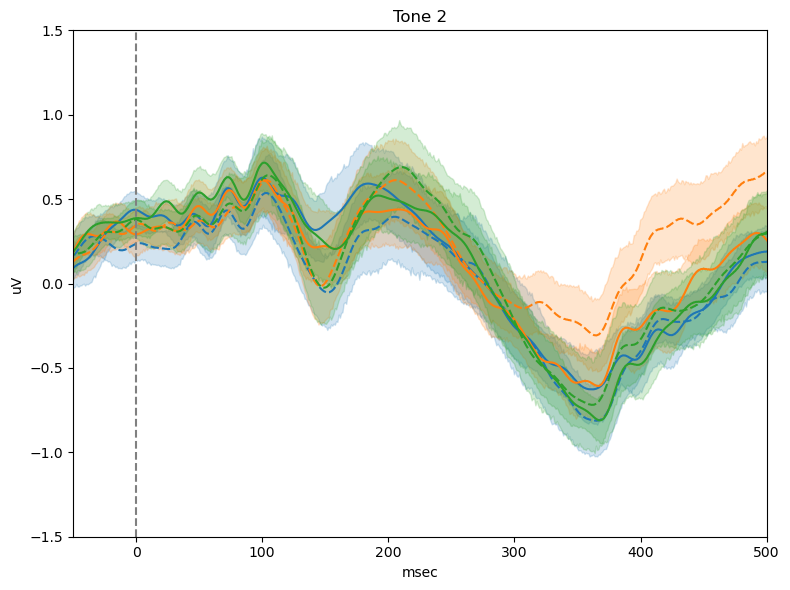

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_tone_2, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax, legend = False)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1.5, 1.5)
graph.set_title('Tone 2')
plt.tight_layout()
plt.savefig('../figs/ERP-tone-2-by-accuracy.png')

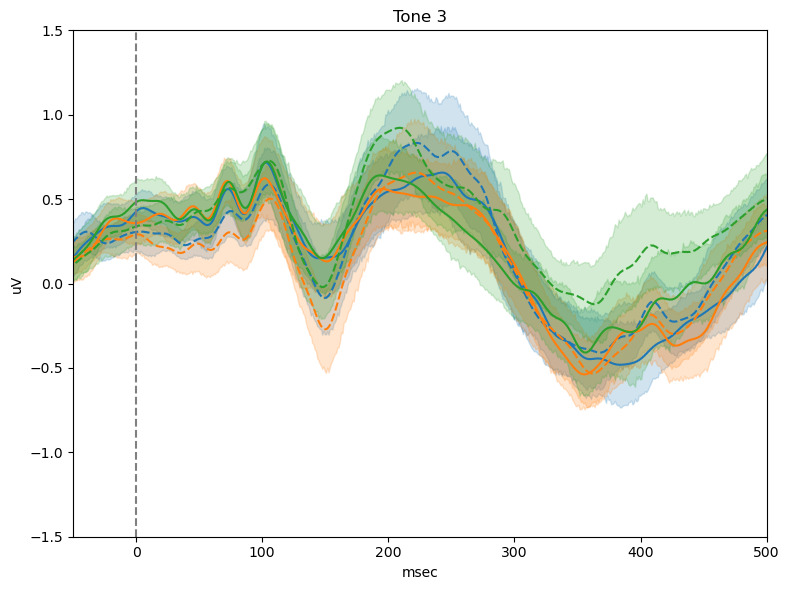

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_tone_3, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax, legend = False)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1.5, 1.5)
graph.set_title('Tone 3')
plt.tight_layout()
plt.savefig('../figs/ERP-tone-3-by-accuracy.png')

# Peaks

### Peak amplitudes values

In [197]:
mean_evokeds = evokeds[evokeds.chan == 'Cz']
mean_evokeds_tone = mean_evokeds.groupby(['tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_target = mean_evokeds.groupby(['target', 'tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_predictable = mean_evokeds.groupby(['tone', 'predictable', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_predictable

,tone,predictable,msec,uV
0,1,False,-173,-0.307981
1,1,False,-172,-0.306429
2,1,False,-171,-0.311632
3,1,False,-170,-0.310827
4,1,False,-169,-0.315662
...,...,...,...,...
4195,3,True,522,0.422711
4196,3,True,523,0.420575
4197,3,True,524,0.424634
4198,3,True,525,0.421811


#### Max at 80-130 msec

In [198]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 80]
seg_tone = seg_tone[seg_tone.msec < 130]

# Tone 1
print(f'Max tone 1: {max(seg_tone.uV[seg_tone.tone == 1])}')
# Tone 2
print(f'Max tone 2: {max(seg_tone.uV[seg_tone.tone == 2])}')
# Tone 3
print(f'Max tone 3: {max(seg_tone.uV[seg_tone.tone == 3])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 80]
seg_target = seg_target[seg_target.msec < 130]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {max(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 1)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {max(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 2)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {max(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 3)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {max(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 1)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {max(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 2)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 3)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {max(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 1)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {max(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 2)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 3)])}')

Max tone 1: 0.6716650643706855
Max tone 2: 0.6233422041406057
Max tone 3: 0.6459089775973507
Max tone 1, target 1: 0.7370843582194868
Max tone 1, target 2: 0.6538851286005641
Max tone 1, target 3: 0.6266543470386466
Max tone 2, target 1: 0.5813501197336282
Max tone 2, target 2: 0.6109257976745743
Max tone 3, target 3: 0.6777506950136148
Max tone 3, target 1: 0.6537617439035857
Max tone 3, target 2: 0.5600764450671744
Max tone 3, target 3: 0.7238887438212922


#### Min at 100-180 msec

In [199]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 100]
seg_tone = seg_tone[seg_tone.msec < 180]

# Tone 1
print(f'Max tone 1: {min(seg_tone.uV[seg_tone.tone == 1])}')
# Tone 2
print(f'Max tone 2: {min(seg_tone.uV[seg_tone.tone == 2])}')
# Tone 3
print(f'Max tone 3: {min(seg_tone.uV[seg_tone.tone == 3])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 100]
seg_target = seg_target[seg_target.msec < 180]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {min(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 1)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {min(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 2)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {min(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 3)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {min(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 1)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {min(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 2)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 3)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {min(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 1)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {min(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 2)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 3)])}')

Max tone 1: 0.1940001180546155
Max tone 2: 0.13158943841971213
Max tone 3: 0.018853548863339707
Max tone 1, target 1: 0.2601116274819454
Max tone 1, target 2: 0.1361944078587753
Max tone 1, target 3: 0.17272538413937372
Max tone 2, target 1: 0.16038412963576287
Max tone 2, target 2: 0.10881491709107727
Max tone 3, target 3: 0.11244318352602675
Max tone 3, target 1: 0.04057828732284424
Max tone 3, target 2: -0.05704129714085939
Max tone 3, target 3: 0.06975156427408355


#### Max at 150-280 msec

In [200]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 150]
seg_tone = seg_tone[seg_tone.msec < 280]

# Tone 1
print(f'Max tone 1: {max(seg_tone.uV[seg_tone.tone == 1])}')
# Tone 2
print(f'Max tone 2: {max(seg_tone.uV[seg_tone.tone == 2])}')
# Tone 3
print(f'Max tone 3: {max(seg_tone.uV[seg_tone.tone == 3])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 150]
seg_target = seg_target[seg_target.msec < 280]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {max(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 1)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {max(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 2)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {max(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 3)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {max(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 1)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {max(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 2)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 3)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {max(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 1)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {max(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 2)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 3)])}')

Max tone 1: 0.7034972229829098
Max tone 2: 0.5200719853135173
Max tone 3: 0.6721611168816141
Max tone 1, target 1: 0.8368436252772306
Max tone 1, target 2: 0.6210245616174879
Max tone 1, target 3: 0.6667290886052092
Max tone 2, target 1: 0.46940443142107946
Max tone 2, target 2: 0.5200845763314116
Max tone 3, target 3: 0.5822272854967032
Max tone 3, target 1: 0.7249761831532262
Max tone 3, target 2: 0.5838545770458771
Max tone 3, target 3: 0.7593718809039139


#### Min at 250-450 msec

In [201]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 250]
seg_tone = seg_tone[seg_tone.msec < 450]

# Tone 1
print(f'Max tone 1: {min(seg_tone.uV[seg_tone.tone == 1])}')
# Tone 2
print(f'Max tone 2: {min(seg_tone.uV[seg_tone.tone == 2])}')
# Tone 3
print(f'Max tone 3: {min(seg_tone.uV[seg_tone.tone == 3])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 250]
seg_target = seg_target[seg_target.msec < 450]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {min(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 1)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {min(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 2)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {min(seg_target.uV[(seg_target.tone == 1) & (seg_target.target == 3)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {min(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 1)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {min(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 2)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 2) & (seg_target.target == 3)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {min(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 1)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {min(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 2)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 3) & (seg_target.target == 3)])}')

Max tone 1: -0.3974153214743294
Max tone 2: -0.6460580299552269
Max tone 3: -0.4058676581197657
Max tone 1, target 1: -0.26891661659299376
Max tone 1, target 2: -0.4325512977401069
Max tone 1, target 3: -0.5361572869898451
Max tone 2, target 1: -0.713421775443705
Max tone 2, target 2: -0.46589740619256653
Max tone 3, target 3: -0.7604142580891141
Max tone 3, target 1: -0.4290190365059245
Max tone 3, target 2: -0.5297540459666291
Max tone 3, target 3: -0.26650406251374553


### Tests on peaks

#### Min at 100-180 msec

<Axes: xlabel='tone', ylabel='uV'>

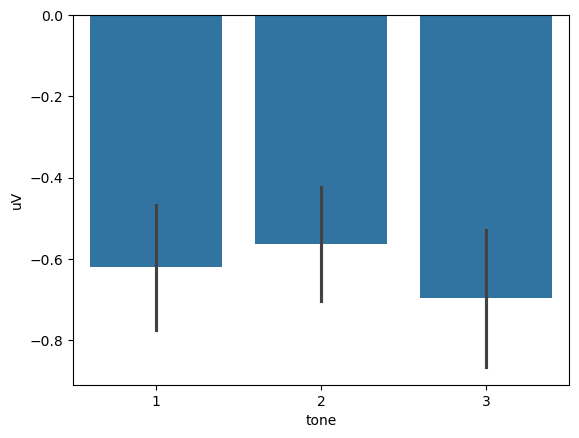

In [202]:
evokeds_cz = evokeds[evokeds.chan == 'Cz']
seg_tone = evokeds_cz[evokeds_cz.msec > 100]
seg_tone = seg_tone[seg_tone.msec < 180]
seg_tone = seg_tone.groupby(['sub', 'tone'], as_index=False)['uV'].min()
seg_tone
sns.barplot(seg_tone, x="tone", y="uV")

<Axes: xlabel='tone', ylabel='uV'>

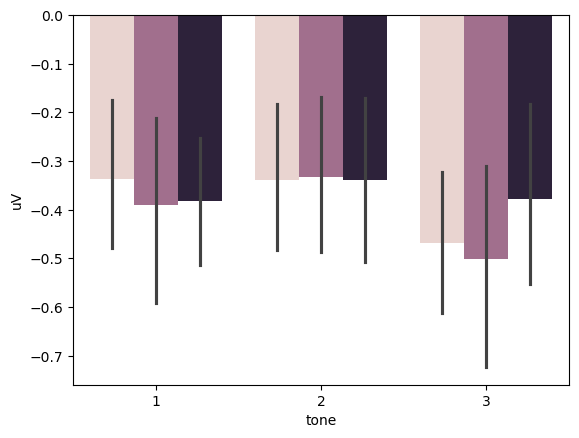

In [203]:
seg_target = evokeds_cz[evokeds_cz.msec > 100]
seg_target = seg_target[seg_target.msec < 180]
seg_target = seg_target.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].min()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="target", legend=False)

#### Max at 150-280 msec

<Axes: xlabel='tone', ylabel='uV'>

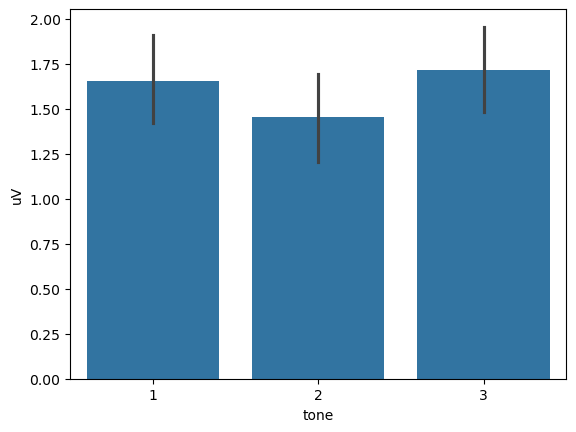

In [204]:
seg_tone = evokeds_cz[evokeds_cz.msec > 150]
seg_tone = seg_tone[seg_tone.msec < 280]
seg_tone = seg_tone.groupby(['sub', 'tone'], as_index=False)['uV'].max()
seg_tone
sns.barplot(seg_tone, x="tone", y="uV")

<Axes: xlabel='tone', ylabel='uV'>

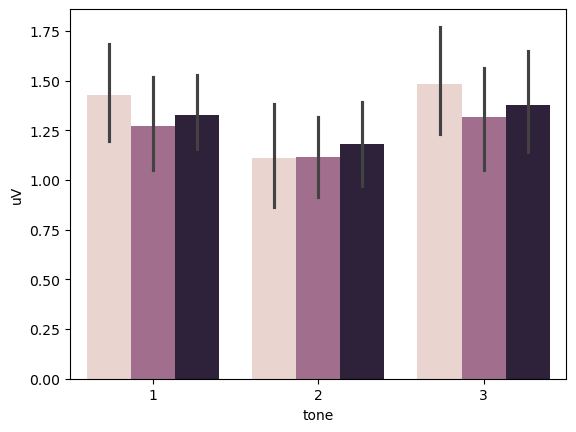

In [205]:
seg_target = evokeds_cz[evokeds_cz.msec > 150]
seg_target = seg_target[seg_target.msec < 280]
seg_target = seg_target.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].max()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="target", legend=False)

#### Min at 250-450 msec

<Axes: xlabel='tone', ylabel='uV'>

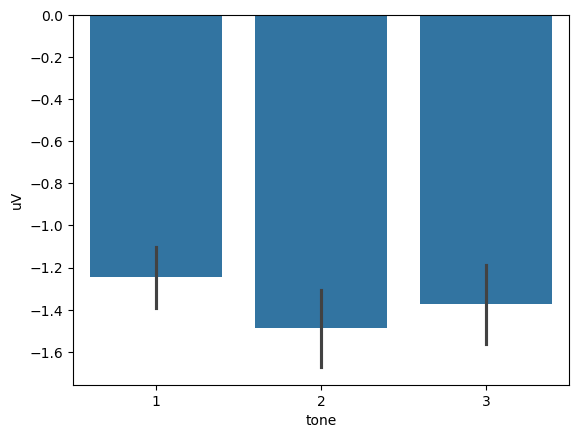

In [206]:
seg_tone = evokeds_cz[evokeds_cz.msec > 250]
seg_tone = seg_tone[seg_tone.msec < 450]
seg_tone = seg_tone.groupby(['sub', 'tone'], as_index=False)['uV'].min()
seg_tone
sns.barplot(seg_tone, x="tone", y="uV")

<Axes: xlabel='tone', ylabel='uV'>

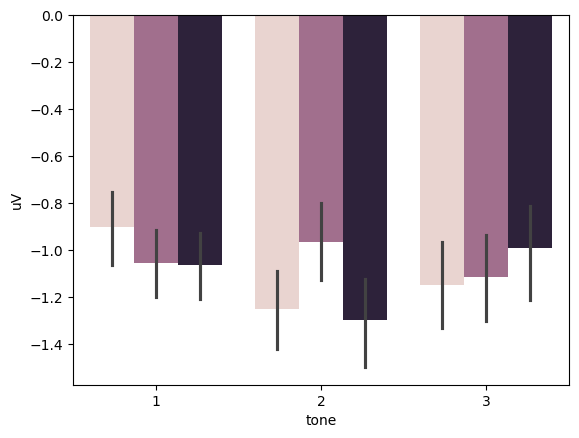

In [225]:
seg_target = evokeds_cz[evokeds_cz.msec > 250]
seg_target = seg_target[seg_target.msec < 450]
seg_target = seg_target.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].min()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="target", legend=False)

In [226]:
aov = AnovaRM(
    data = seg_target[seg_target.tone == 2], 
    depvar = 'uV',
    subject = 'sub', 
    within = ['target']
)
res = aov.fit()
print(res)

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
target  7.1278 2.0000 62.0000 0.0016



#### Inflection point at 430 msec (Important)

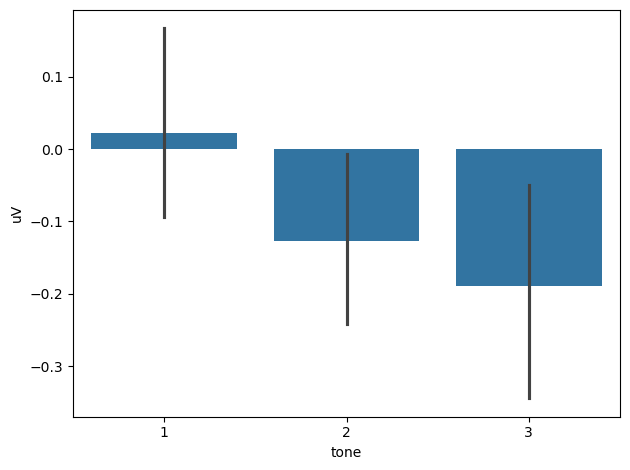

In [208]:
seg_tone = evokeds_cz[evokeds_cz.msec == 425]
seg_tone = seg_tone.groupby(['sub', 'tone'], as_index=False)['uV'].mean()
seg_tone
sns.barplot(seg_tone, x="tone", y="uV")
plt.tight_layout()
plt.savefig('../figs/ERP-inflection-by-tone.png')

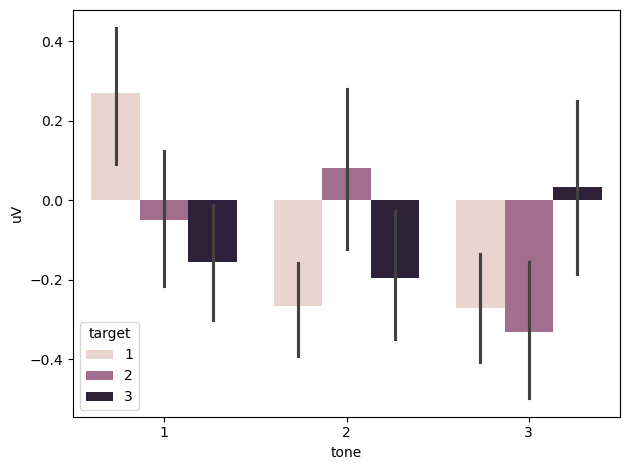

In [209]:
seg_target = evokeds_cz[evokeds_cz.msec == 425]
seg_target = seg_target.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].mean()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="target")
plt.tight_layout()
plt.savefig('../figs/ERP-inflection-by-target.png')

#### Tests on the inflection point

In [210]:
# 3x3
aov = AnovaRM(
    data = seg_target, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['tone', 'target']
)
res = aov.fit()
print(res)

# for tone 1
aov = AnovaRM(
    data = seg_target[seg_target.tone == 1], 
    depvar = 'uV',
    subject = 'sub', 
    within = ['target']
)
res = aov.fit()
print(res)

# for tone 2
aov = AnovaRM(
    data = seg_target[seg_target.tone == 2], 
    depvar = 'uV',
    subject = 'sub', 
    within = ['target']
)
res = aov.fit()
print(res)

# for tone 3
aov = AnovaRM(
    data = seg_target[seg_target.tone == 3], 
    depvar = 'uV',
    subject = 'sub', 
    within = ['target']
)
res = aov.fit()
print(res)

                  Anova
            F Value Num DF  Den DF  Pr > F
------------------------------------------
tone         8.0351 2.0000  62.0000 0.0008
target       0.1174 2.0000  62.0000 0.8895
tone:target  8.9814 4.0000 124.0000 0.0000

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
target 10.2457 2.0000 62.0000 0.0001

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
target  6.1482 2.0000 62.0000 0.0037

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
target  7.7356 2.0000 62.0000 0.0010



##### Factor in accuracies

0.13262961455530378
0.36675254200959334


TtestResult(statistic=-1.1797828169851874, pvalue=0.24735780332200463, df=30.0)

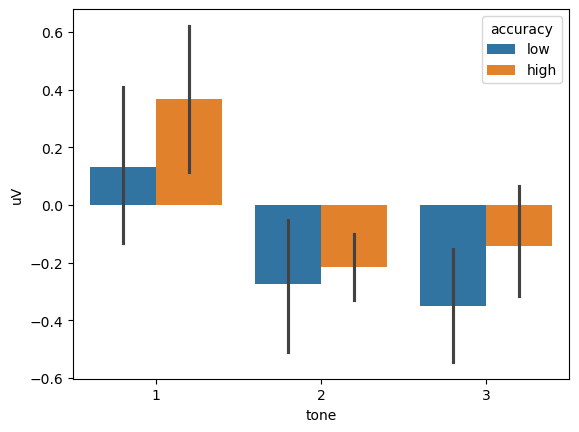

In [224]:
mean_evokeds = evokeds_cz[evokeds_cz.target == 1]

# Plot
seg_target = mean_evokeds[mean_evokeds.msec == 415]
seg_target = seg_target.groupby(['sub', 'tone', 'accuracy'], as_index=False)['uV'].mean()
sns.barplot(seg_target, x="tone", y="uV", hue="accuracy")

# Test
seg_target = evokeds_cz[(evokeds_cz.target == 1) & (evokeds_cz.tone == 1) & (evokeds_cz.msec == 415)]
seg_target = seg_target.groupby(['sub', 'accuracy'], as_index=False)['uV'].mean()
print(seg_target.uV[seg_target.accuracy == 'low'].mean())
print(seg_target.uV[seg_target.accuracy == 'high'].mean())
stats.ttest_ind(seg_target.uV[seg_target.accuracy == 'low'], seg_target.uV[seg_target.accuracy == 'high'])


-0.12318909088371743
0.3811819211339744


TtestResult(statistic=-2.656066628237479, pvalue=0.01253856002439053, df=30.0)

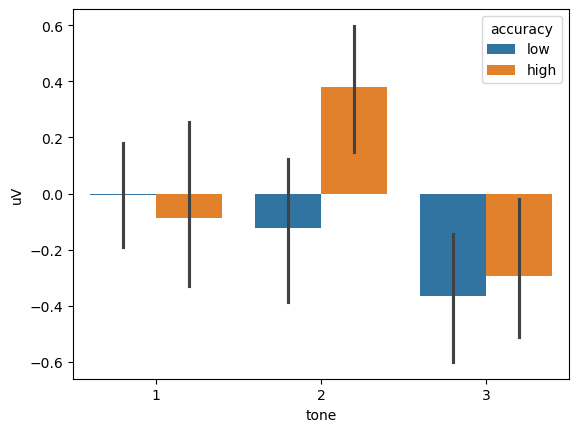

In [218]:
mean_evokeds = evokeds_cz[evokeds_cz.target == 2]
seg_target = mean_evokeds[mean_evokeds.msec == 430]
seg_target = seg_target.groupby(['sub', 'tone', 'accuracy'], as_index=False)['uV'].mean()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="accuracy")

# Test
seg_target = evokeds_cz[(evokeds_cz.target == 2) & (evokeds_cz.tone == 2) & (evokeds_cz.msec == 430)]
seg_target = seg_target.groupby(['sub', 'accuracy'], as_index=False)['uV'].mean()
print(seg_target.uV[seg_target.accuracy == 'low'].mean())
print(seg_target.uV[seg_target.accuracy == 'high'].mean())
stats.ttest_ind(seg_target.uV[seg_target.accuracy == 'low'], seg_target.uV[seg_target.accuracy == 'high'])

-0.12174107708439008
0.22507811964534177


TtestResult(statistic=-1.4422073522138967, pvalue=0.15960332857829773, df=30.0)

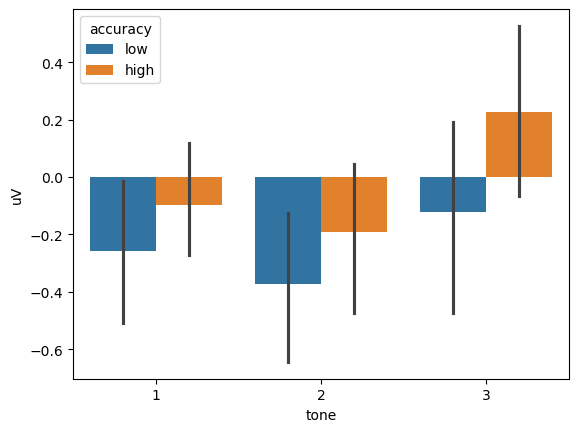

In [220]:
mean_evokeds = evokeds_cz[evokeds_cz.target == 3]
seg_target = mean_evokeds[mean_evokeds.msec == 410]
seg_target = seg_target.groupby(['sub', 'tone', 'accuracy'], as_index=False)['uV'].mean()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="accuracy")

# Test
seg_target = evokeds_cz[(evokeds_cz.target == 3) & (evokeds_cz.tone == 3) & (evokeds_cz.msec == 410)]
seg_target = seg_target.groupby(['sub', 'accuracy'], as_index=False)['uV'].mean()
print(seg_target.uV[seg_target.accuracy == 'low'].mean())
print(seg_target.uV[seg_target.accuracy == 'high'].mean())
stats.ttest_ind(seg_target.uV[seg_target.accuracy == 'low'], seg_target.uV[seg_target.accuracy == 'high'])

In [215]:
seg_target

,sub,tone,accuracy,uV
0,4,1,low,-0.327265
1,4,2,low,-1.158327
2,4,3,low,0.364585
3,7,1,low,0.194290
4,7,2,low,-0.228889
...,...,...,...,...
91,40,2,high,0.860377
92,40,3,high,0.760959
93,41,1,high,0.260520
94,41,2,high,0.227644


In [216]:
seg_target = evokeds[evokeds.msec == 420]
seg_target = seg_target.groupby(['sub', 'tone', 'target', 'accuracy'], as_index=False)['uV'].mean()
# seg_target = seg_target[seg_target['sub'] != 41]

# With accuracy
aov = AnovaRM(
    data = seg_target, 
    depvar = 'uV',
    subject = 'sub', 
    between = 'accuracy',
    within = ['tone', 'tone']
)
res = aov.fit()
print(res)

NotImplementedError: Between subject effect not yet supported!

# Latencies

In [ ]:
mean_evokeds = evokeds[evokeds.chan == 'Cz']
mean_evokeds_tone = mean_evokeds.groupby(['chan', 'tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_target = mean_evokeds.groupby(['chan', 'target', 'tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_target

#### Min at 100-180 msec

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 100]
seg_tone = seg_tone[seg_tone.msec < 180]

# # Tone 1
tmp = seg_tone[(seg_tone.tone == 1)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1: {lat}')
# # Tone 2
tmp = seg_tone[(seg_tone.tone == 2)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2: {lat}')
# # Tone 3
tmp = seg_tone[(seg_tone.tone == 3)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3: {lat}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 100]
seg_target = seg_target[seg_target.msec < 180]

# Tone 1 when tone 1 is target
tmp = seg_target[(seg_target.tone == 1) & (seg_target.target == 1)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 1: {lat}')
# Tone 1 when tone 2 is target
tmp = seg_target[(seg_target.tone == 1) & (seg_target.target == 2)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 2: {lat}')
# Tone 1 when tone 3 is target
tmp = seg_target[(seg_target.tone == 1) & (seg_target.target == 3)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 3: {lat}')

# Tone 2 when tone 1 is target
tmp = seg_target[(seg_target.tone == 2) & (seg_target.target == 1)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 1: {lat}')
# Tone 2 when tone 2 is target
tmp = seg_target[(seg_target.tone == 2) & (seg_target.target == 2)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 2: {lat}')
# Tone 2 when tone 3 is target
tmp = seg_target[(seg_target.tone == 2) & (seg_target.target == 3)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 3: {lat}')

# Tone 3 when tone 1 is target
tmp = seg_target[(seg_target.tone == 3) & (seg_target.target == 1)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 1: {lat}')
# Tone 3 when tone 2 is target
tmp = seg_target[(seg_target.tone == 3) & (seg_target.target == 2)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 2: {lat}')
# Tone 3 when tone 3 is target
tmp = seg_target[(seg_target.tone == 3) & (seg_target.target == 3)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 3: {lat}')

#### Max at 150-280 msec

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 150]
seg_tone = seg_tone[seg_tone.msec < 280]

# # Tone 1
tmp = seg_tone[(seg_tone.tone == 1)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1: {lat}')
# # Tone 2
tmp = seg_tone[(seg_tone.tone == 2)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2: {lat}')
# # Tone 3
tmp = seg_tone[(seg_tone.tone == 3)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3: {lat}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 150]
seg_target = seg_target[seg_target.msec < 280]

# Tone 1 when tone 1 is target
tmp = seg_target[(seg_target.tone == 1) & (seg_target.target == 1)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1, target 1: {lat}')
# Tone 1 when tone 2 is target
tmp = seg_target[(seg_target.tone == 1) & (seg_target.target == 2)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1, target 2: {lat}')
# Tone 1 when tone 3 is target
tmp = seg_target[(seg_target.tone == 1) & (seg_target.target == 3)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1, target 3: {lat}')

# Tone 2 when tone 1 is target
tmp = seg_target[(seg_target.tone == 2) & (seg_target.target == 1)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2, target 1: {lat}')
# Tone 2 when tone 2 is target
tmp = seg_target[(seg_target.tone == 2) & (seg_target.target == 2)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2, target 2: {lat}')
# Tone 2 when tone 3 is target
tmp = seg_target[(seg_target.tone == 2) & (seg_target.target == 3)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2, target 3: {lat}')

# Tone 3 when tone 1 is target
tmp = seg_target[(seg_target.tone == 3) & (seg_target.target == 1)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3, target 1: {lat}')
# Tone 3 when tone 2 is target
tmp = seg_target[(seg_target.tone == 3) & (seg_target.target == 2)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3, target 2: {lat}')
# Tone 3 when tone 3 is target
tmp = seg_target[(seg_target.tone == 3) & (seg_target.target == 3)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3, target 3: {lat}')

#### Min at 250-450 msec (important)

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 250]
seg_tone = seg_tone[seg_tone.msec < 450]

# # Tone 1
tmp = seg_tone[(seg_tone.tone == 1)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1: {lat}')
# # Tone 2
tmp = seg_tone[(seg_tone.tone == 2)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2: {lat}')
# # Tone 3
tmp = seg_tone[(seg_tone.tone == 3)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3: {lat}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 250]
seg_target = seg_target[seg_target.msec < 450]

# Tone 1 when tone 1 is target
tmp = seg_target[(seg_target.tone == 1) & (seg_target.target == 1)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 1: {lat}')
# Tone 1 when tone 2 is target
tmp = seg_target[(seg_target.tone == 1) & (seg_target.target == 2)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 2: {lat}')
# Tone 1 when tone 3 is target
tmp = seg_target[(seg_target.tone == 1) & (seg_target.target == 3)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 3: {lat}')

# Tone 2 when tone 1 is target
tmp = seg_target[(seg_target.tone == 2) & (seg_target.target == 1)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 1: {lat}')
# Tone 2 when tone 2 is target
tmp = seg_target[(seg_target.tone == 2) & (seg_target.target == 2)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 2: {lat}')
# Tone 2 when tone 3 is target
tmp = seg_target[(seg_target.tone == 2) & (seg_target.target == 3)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 3: {lat}')

# Tone 3 when tone 1 is target
tmp = seg_target[(seg_target.tone == 3) & (seg_target.target == 1)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 1: {lat}')
# Tone 3 when tone 2 is target
tmp = seg_target[(seg_target.tone == 3) & (seg_target.target == 2)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 2: {lat}')
# Tone 3 when tone 3 is target
tmp = seg_target[(seg_target.tone == 3) & (seg_target.target == 3)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 3: {lat}')

#### Tests on latencies

In [ ]:
evokeds

In [ ]:
predictability = [True, False]

def get_latencies_tone(evokeds, start, end, peak_type):
    all_lat = []
    tones = [1, 2, 3]
    for sub in np.unique(evokeds['sub']):
        for tone in tones:
            evokeds_cz = evokeds[evokeds.chan == 'Cz']
            evokeds_sub = evokeds_cz[evokeds_cz['sub'] == sub]
            seg = evokeds_sub[evokeds_sub.msec > start]
            seg = seg[seg.msec < end]
            seg = seg[seg.tone == tone]
            if peak_type == 'min':
                peak = min(seg.uV)
            elif peak_type == 'max':
                peak = max(seg.uV)
            lat = int(seg.msec[seg.uV == peak])
            df = pd.DataFrame({
                'sub': [sub],
                'start': [start],
                'end': [end],
                'tone': [tone],
                'peak_type': [peak_type],
                'peak': [peak],
                'latency': [lat],
            })
            all_lat.append(df)
    all_lat = pd.concat(all_lat)
    return all_lat
    
def get_latencies_target(evokeds, start, end, peak_type):
    all_lat = []
    tones = [1, 2, 3]
    for sub in np.unique(evokeds['sub']):
        for tone in tones:
            for target in tones:
                evokeds_cz = evokeds[evokeds.chan == 'Cz']
                evokeds_sub = evokeds_cz[evokeds_cz['sub'] == sub]
                seg = evokeds_sub[evokeds_sub.msec > start]
                seg = seg[seg.msec < end]
                seg = seg[(seg.tone == tone) & (seg.target == target)]
                if peak_type == 'min':
                    peak = min(seg.uV)
                elif peak_type == 'max':
                    peak = max(seg.uV)
                lat = int(seg.msec[seg.uV == peak])
                df = pd.DataFrame({
                    'sub': [sub],
                    'start': [start],
                    'end': [end],
                    'tone': [tone],
                    'target': [target],
                    'peak_type': [peak_type],
                    'peak': [peak],
                    'latency': [lat],
                })
                all_lat.append(df)
    all_lat = pd.concat(all_lat)
    return all_lat

#### Min at 100-180 msec

In [ ]:
latencies_tone = get_latencies_tone(evokeds, 100, 180, 'min')
latencies_target = get_latencies_target(evokeds, 100, 180, 'min')

In [ ]:
sns.barplot(latencies_tone, x = "tone", y = "latency")

In [ ]:
sns.barplot(latencies_target, x = "tone", y = "latency", hue = "target")

#### Max at 150-280 msec

In [ ]:
latencies_tone = get_latencies_tone(evokeds, 150, 280, 'max')
latencies_target = get_latencies_target(evokeds, 150, 280, 'max')

In [ ]:
sns.barplot(latencies_tone, x = "tone", y = "latency")

In [ ]:
sns.barplot(latencies_target, x = "tone", y = "latency", hue = "target")

#### Min at 250-450 msec (important)

In [ ]:
latencies_tone = get_latencies_tone(evokeds, 250, 450, 'min')
latencies_target = get_latencies_target(evokeds, 250, 450, 'min')

In [ ]:
sns.barplot(latencies_tone, x = "tone", y = "latency")

In [ ]:
sns.barplot(latencies_target, x = "tone", y = "latency", hue = "target")

# Predictability

### Peaks

In [ ]:
# print(len(np.unique(seg['sub'])))
# for sub in np.unique(seg['sub']):
#     print(sub)
#     print(np.shape(seg[seg['sub'] == sub]))
mean_evokeds_predictable = mean_evokeds_predictable[mean_evokeds_predictable['sub'] != 33]
mean_evokeds_predictable

#### Max at 80-130 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 80]
seg = seg[seg.msec < 130]

# Tone 1
seg_1 = seg[seg.tone == 1]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 2]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 3]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

#### Min at 100-180 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 100]
seg = seg[seg.msec < 180]

# Tone 1
seg_1 = seg[seg.tone == 1]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 2]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 3]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

#### Max at 150-280 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 150]
seg = seg[seg.msec < 280]

# Tone 1
seg_1 = seg[seg.tone == 1]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 2]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 3]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

#### Min at 250-450 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 250]
seg = seg[seg.msec < 450]

# Tone 1
seg_1 = seg[seg.tone == 1]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 2]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 3]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

### Latencies

In [ ]:
def get_latencies_predictable(evokeds, start, end, peak_type):
    all_lat = []
    tones = [1, 2, 3]
    predictable = [True, False]
    for sub in np.unique(evokeds['sub']):
        for tone in tones:
            for predictability in predictable:
                evokeds_cz = evokeds[evokeds.chan == 'Cz']
                evokeds_sub = evokeds_cz[evokeds_cz['sub'] == sub]
                seg = evokeds_sub[evokeds_sub.msec > start]
                seg = seg[seg.msec < end]
                seg = seg[(seg.tone == tone) & (seg.predictable == predictability)]
                if peak_type == 'min':
                    peak = min(seg.uV)
                elif peak_type == 'max':
                    peak = max(seg.uV)
                lat = int(seg.msec[seg.uV == peak])
                df = pd.DataFrame({
                    'sub': [sub],
                    'start': [start],
                    'end': [end],
                    'tone': [tone],
                    'predictable': [predictability],
                    'peak_type': [peak_type],
                    'peak': [peak],
                    'latency': [lat],
                })
                all_lat.append(df)
    all_lat = pd.concat(all_lat)
    return all_lat
evokeds_drop = evokeds[evokeds['sub'] != 33]

In [ ]:
latencies_predictable = get_latencies_predictable(evokeds_drop, 80, 130, "max")
sns.barplot(latencies_tone, x = "predictable", y = "latency")

In [ ]:
mean_evokeds = mean_evokeds[mean_evokeds.chan == 'Cz']
seg_target = mean_evokeds[mean_evokeds.msec > 250]
seg_target = seg_target[seg_target.msec < 450]
seg_target = seg_target.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].min()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="target", legend=False)

In [ ]:
# 3x3
aov = AnovaRM(
    data = seg_target, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['tone', 'target']
)
res = aov.fit()
print(res)

# for tone 1
aov = AnovaRM(
    data = seg_target[seg_target.tone == 1], 
    depvar = 'uV',
    subject = 'sub', 
    within = ['target']
)
res = aov.fit()
print(res)

# for tone 2
aov = AnovaRM(
    data = seg_target[seg_target.tone == 2], 
    depvar = 'uV',
    subject = 'sub', 
    within = ['target']
)
res = aov.fit()
print(res)

# for tone 3
aov = AnovaRM(
    data = seg_target[seg_target.tone == 3], 
    depvar = 'uV',
    subject = 'sub', 
    within = ['target']
)
res = aov.fit()
print(res)

In [ ]:
evokeds_tone_1 = evokeds[evokeds.tone == 1] 
evokeds_tone_1 = evokeds_tone_1[evokeds_tone_1.accuracy != 'none']
evokeds_tone_1 = evokeds_tone_1[evokeds_tone_1.target == 1]
evokeds_target_Cz = evokeds_tone_1[evokeds_tone_1.chan == 'Cz']
evokeds_target_Fz = evokeds_tone_1[evokeds_tone_1.chan == 'Fz']
evokeds_target_FCz = evokeds_tone_1[evokeds_tone_1.chan == 'FCz']
evokeds_target_CPz = evokeds_tone_1[evokeds_tone_1.chan == 'CPz']
evokeds_target_Pz = evokeds_tone_1[evokeds_tone_1.chan == 'Pz']

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Cz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('Cz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Fz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('Fz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_FCz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('FCz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_CPz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('CPz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Pz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('Pz')

In [ ]:
evokeds_tone_2 = evokeds[evokeds.tone == 2] 
evokeds_tone_2 = evokeds_tone_2[evokeds_tone_2.accuracy != 'none']
evokeds_tone_2 = evokeds_tone_2[evokeds_tone_2.target == 2]
evokeds_target_Cz = evokeds_tone_2[evokeds_tone_2.chan == 'Cz']
evokeds_target_Fz = evokeds_tone_2[evokeds_tone_2.chan == 'Fz']
evokeds_target_FCz = evokeds_tone_2[evokeds_tone_2.chan == 'FCz']
evokeds_target_CPz = evokeds_tone_2[evokeds_tone_2.chan == 'CPz']
evokeds_target_Pz = evokeds_tone_2[evokeds_tone_2.chan == 'Pz']

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Cz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('Cz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Fz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('Fz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_FCz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('FCz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_CPz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('CPz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Pz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Pz')

In [ ]:
evokeds_tone_3 = evokeds[evokeds.tone == 3] 
evokeds_tone_3 = evokeds_tone_3[evokeds_tone_3.accuracy != 'none']
evokeds_tone_3 = evokeds_tone_3[evokeds_tone_3.target == 3]
evokeds_target_Cz = evokeds_tone_3[evokeds_tone_3.chan == 'Cz']
evokeds_target_Fz = evokeds_tone_3[evokeds_tone_3.chan == 'Fz']
evokeds_target_FCz = evokeds_tone_3[evokeds_tone_3.chan == 'FCz']
evokeds_target_CPz = evokeds_tone_3[evokeds_tone_3.chan == 'CPz']
evokeds_target_Pz = evokeds_tone_3[evokeds_tone_3.chan == 'Pz']

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Cz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('Cz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Fz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('Fz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_FCz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('FCz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_CPz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 300)
graph.set_title('CPz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Pz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Pz')